### Supervised Machine Learning Techniques II

### Mortgage Default Risk & Fraud Detection

### Author: Chloe Du (jd3631)

#### Question and problem definition

Knowing from a training set of samples listing loan applicants who defaulted or did not default, can our model determine based on a given test dataset not containing the default information, if these applicants in the test dataset defaulted or not.

#### Part 1: Review the data

In [1]:
#import necessary libraries
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
np.random.seed(0)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split

There are 80,000 distinct mortgage loan applicants and there are 89 different features.

There are many missing data in the whole dataset. We will deal with these missing values later.

The most common operation used when applying for loan is h5, and the most comman mobile brand used is web.

The target value is loan_default. This indicates if a client will default mortage loan in the future. As the value 0 for default payment means not default and value 1 means default, the mean of 0.1936 means that there are 19.36% of mortgage loan contracts that will default (will verify this in the next sections of this analysis).

We will explore in more detail the data in the following section.

#### Acquire data

In [2]:
# Now to import and put the dataset 
df = pd.read_csv("/Users/jiayangdu/Desktop/Columbia University /APAN 5420/XYZloan_default_selected_vars.csv")
# preview the data
df.head()

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [3]:
##adjust the varibles, drop meaningless variables
df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [4]:
#id has no meaning of value, so we convert it to categorical variables
df['id'] = df['id'].apply(lambda x:str(x))
#AP005 represents the datetime, so we need to convert it to datetime type
df['AP005'] = pd.to_datetime(df['AP005'])

df.info()
#there are some missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 87 columns):
id              80000 non-null object
loan_default    80000 non-null int64
AP001           80000 non-null int64
AP002           80000 non-null int64
AP003           80000 non-null int64
AP004           80000 non-null int64
AP005           80000 non-null datetime64[ns]
AP006           80000 non-null object
AP007           80000 non-null int64
AP008           80000 non-null int64
AP009           80000 non-null int64
TD001           80000 non-null int64
TD002           80000 non-null int64
TD005           80000 non-null int64
TD006           80000 non-null int64
TD009           80000 non-null int64
TD010           80000 non-null int64
TD013           80000 non-null int64
TD014           80000 non-null int64
TD015           80000 non-null int64
TD022           60402 non-null float64
TD023           72337 non-null float64
TD024           76306 non-null float64
TD025           77450 n

In [5]:
#replace -1,-99,-98,-999 to na, since these two strange values may be systematic default value
df.replace(-99.0,' ',inplace=True)
df.replace(-99,' ',inplace=True)
df.replace(-98.0,' ',inplace=True)
df.replace(-98,' ',inplace=True)
df.replace(-999,' ',inplace=True)
df.replace(-99.0,' ',inplace=True)
df.replace(-1,' ',inplace=True)
#replace all empty string to nan
df.replace(r'^\s+$', np.nan, regex=True, inplace = True)

In [6]:
df.head() #missing values have been successfully replaced

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017-07-06 10:21:00,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017-04-06 12:51:00,h5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB
2,3,0,33,1,4,12,2017-07-01 14:11:00,h5,4,2,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,4,0,34,2,4,12,2017-07-07 10:10:00,android,5,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,5,0,47,2,1,12,2017-07-06 14:37:00,h5,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEB


In [7]:
#missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
TD048,79999,0.999988
TD055,79999,0.999988
TD062,79999,0.999988
TD044,79997,0.999962
TD051,79995,0.999938
TD061,79990,0.999875
TD054,79988,0.999850
PA030,69801,0.872513
PA023,57919,0.723988
PA031,57919,0.723988


In [8]:
#from the above dataframe, we can see that there are some variables missing almost 100% values
#therefore, i will drop those variables which lose up to 50% values
df.drop(['TD055','TD062','TD048','TD044','TD051','TD061','TD054','PA030','PA023','PA031','PA029','PA022','PA028'],axis=1,inplace=True)
# for other columns containing missing values, we do not need to deal with them
# since in the following steps, we will bin some variables and missing values will be regarded as their own categories
# the tree-based algorithms will capture the information from nah values

In [9]:
#get statistics info about numerical variables
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,...,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,...,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,76312.000000,77207.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,...,11.501677,19.180352,16.573750,952.775121,850.212037,1812.070212,1610.332071,2626.427993,2330.516878,5.976272
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,...,17.641851,30.743372,24.496918,1392.729146,1256.936168,2463.242747,2191.780118,3433.330482,3029.857757,3.641814
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,...,3.000000,6.000000,5.000000,123.000000,76.000000,382.000000,294.000000,649.000000,512.000000,3.000000
50%,0.000000,30.000000,1.000000,1.000000,12.000000,3.00000,3.000000,1.000000,2.000000,0.000000,...,7.000000,13.000000,11.000000,518.000000,437.000000,1098.000000,940.000000,1658.000000,1423.000000,5.000000
75%,0.000000,35.000000,2.000000,3.000000,12.000000,5.00000,4.000000,1.000000,3.000000,1.000000,...,14.000000,24.000000,21.000000,1258.000000,1123.000000,2369.000000,2107.000000,3417.000000,3037.000000,8.000000
max,1.000000,56.000000,2.000000,6.000000,12.000000,5.00000,5.000000,1.000000,20.000000,11.000000,...,1061.000000,2792.000000,1579.000000,48585.000000,29664.000000,88364.000000,54651.000000,125352.000000,87312.000000,47.000000


In [10]:
#since after replacing, some numerical categories will become categorical
#so we should convert the data types
df_cat = df.describe(include=['O']).drop(['id','MB007','AP006'],axis=1)
num_columns = df_cat.columns
for col in num_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
#Take a quick look at some basic categorical data
df.describe(include=['O'])
#we can see there is no duplicate applicants 
#h5 is the most common operation system 
#web is the most common operation device

,id,AP006,MB007
count,80000,80000,80000
unique,80000,4,112
top,26112,h5,WEB
freq,1,44246,43850


##### Analyze by pivoting features

In [11]:
df[['AP006', 'loan_default']].groupby(['AP006'], as_index=False).mean().sort_values(by='loan_default', ascending=False)

,AP006,loan_default
0,android,0.222287
1,api,0.194502
2,h5,0.187249
3,ios,0.181246


In [12]:
df[['MB007', 'loan_default']].groupby(['MB007'], as_index=False).mean().sort_values(by='loan_default', ascending=False)

,MB007,loan_default
111,ZUOKU,1.0
83,ROAM_CAT,1.0
28,HASEE,1.0
30,HMI,1.0
31,HONGLAJIAO,1.0
...,...,...
82,REDGOO,0.0
10,BIRD,0.0
50,KDDI,0.0
85,SGMSGMS,0.0


##### datetime variable

In [13]:
#we cannot employ any DateTime field of the yymmdd:hhmmss format in any tree-based methods. 
# derive year, month, day, weekday, etc. from this field.
df = df.assign(hour=df.AP005.dt.hour,
               day=df.AP005.dt.day,
               month=df.AP005.dt.month,
               year=df.AP005.dt.year)

In [14]:
df['DayofWeek']=df['AP005'].apply(lambda x:x.dayofweek)

In [15]:
#drop unwanted columns
df.drop('AP005',axis=1,inplace=True)

#### Part 2: Target Variable

 Note: our target variable is "loan_default", so we have a logistic problem (0 or 1)

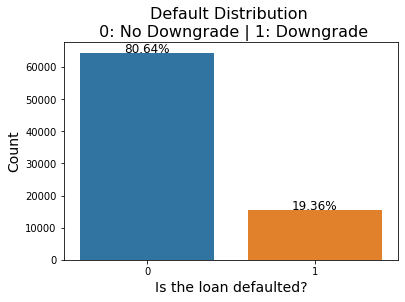

In [16]:
#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plot_tr = sns.countplot(x='loan_default', data=df)
plot_tr.set_title("Default Distribution \n 0: No Downgrade | 1: Downgrade", fontsize=16)
plot_tr.set_xlabel("Is the loan defaulted?", fontsize=14)
plot_tr.set_ylabel('Count', fontsize=14)
total = len(df)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

A 20% target incidence considering the amount of data in the dataset could work, however the proportion is still very small and I consider it to be imbalanced. 

### Model : GLM

In [17]:
# To copy the dataset for this modelling
df1 = df.copy()

#### Outliers flooring or capping

calculate 99% and 1% percentile as cap and floor for each column, the if value >= 99% percentile then redefine the value as the value of 99% percentile; similarly if value <= 1% percentile then redefine value as the value of 1% percentile

In [18]:
###find out those numerical variables
###make it easier for the following steps (binning continuous variables)
numerical_columns = ['AP001','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014',
                     'TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029',
                     'CR004','CR005','CR012','CR015','CR017','CR018','CR019','CD008','CD018',
                     'CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113',
                     'CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131',
                     'CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164',
                     'CD166','CD167','CD169','CD170','CD172','CD173','MB005']
ordinal_columns = ['AP002','AP003','AP004','AP007','AP008','AP009','AP006','MB007','year','month','day','hour','DayofWeek']

In [19]:
for col in numerical_columns:
    percentiles = df1[col].quantile([0.01,0.99]).values
    df1[col][df1[col] <= percentiles[0]] = percentiles[0]
    df1[col][df1[col] >= percentiles[1]] = percentiles[1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

#### missing values

We need to impute missing values up front if there are many.

Then use fillna() to impute the missing values with the median values(not use mean since mean is influenced by outliers) for numerical values, while impute with mode values for categorical/ordinal columns. Use the for-loop function to impute missing values for those columns.

In [20]:
def null_cell(df):
    missing_values = df.isnull().sum()
    missing_values_per = df.isnull().sum() / df.isnull().count()
    null_values = pd.concat([missing_values, missing_values_per],axis=1, keys = ['the_null','the_null_perc'])
    null_values = null_values.sort_values('the_null',ascending=False)
    return null_values[null_values['the_null']>0]

In [21]:
#for numerical columns, fill in the median values
fill_list = (null_cell(df1[numerical_columns])).index
print(fill_list)
for col in fill_list:
    df1.loc[:,col].fillna(df1.loc[:,col].median(),inplace=True)

Index(['TD022', 'TD023', 'TD024', 'CD123', 'CD121', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD101', 'CD131', 'CD100', 'CD120', 'CD106', 'CD107',
       'CD108', 'CD113', 'CD114', 'CD115', 'CD130', 'CD133', 'CD132', 'CD164',
       'CD173', 'CD172', 'CD170', 'CD169', 'CD167', 'CD166', 'CD162', 'CD118',
       'CD160', 'CD153', 'CD152', 'CD137', 'CD136', 'CD135', 'CD117', 'MB005',
       'TD025', 'TD026', 'TD027', 'TD028', 'TD029'],
      dtype='object')


In [22]:
#for ordinal/cat columns, fill in mode 
fill_list_2 = (null_cell(df1[ordinal_columns])).index
print(fill_list_2)
for col in fill_list_2:
    df1.loc[:,col].fillna(df1.loc[:,col].mode(),inplace=True)

Index([], dtype='object')


In [23]:
#missing values
sum(df1.isnull().sum()) #we've gotten rid of all our NAs

0

#### Categorical variables

"Letting GLM handle categorical columns is better, as it can take advantage of the categorical column for better performance and memory utilization. We strongly recommend avoiding one-hot encoding categorical columns with many levels into many binary columns, as this is very inefficient. This is especially true for Python users who are used to expanding their categorical variables manually for other frameworks."

h2o will automatically expands categoricals into 1-hot encoded binary vectors

reference:https://www.h2o.ai/wp-content/uploads/2018/01/GLM-BOOKLET.pdf

In [24]:
#Create list with categorical features' names.
#AP002gender, AP003 education level,  Ap004 loan_term (3,6,12), AP007 level_apply_city, AP008 FLAG_IP_CITY_NOT_APPL_CITY, 
#ordinal_columns = ['AP002','AP003','AP004','AP007','AP008','AP009','AP006','MB007','year','month','day','hour','DayofWeek']
#Assign appropriate data type to categorical variables.
nonum_feats = df1[ordinal_columns].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 13 columns):
AP002        80000 non-null category
AP003        80000 non-null category
AP004        80000 non-null category
AP007        80000 non-null category
AP008        80000 non-null category
AP009        80000 non-null category
AP006        80000 non-null category
MB007        80000 non-null category
year         80000 non-null category
month        80000 non-null category
day          80000 non-null category
hour         80000 non-null category
DayofWeek    80000 non-null category
dtypes: category(13)
memory usage: 1.0 MB


In [25]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(nonum_feats,drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 194 entries, AP002_2 to DayofWeek_6
dtypes: uint8(194)
memory usage: 14.8 MB


#### numerical variables

exploratory on the correlation between numerical variables

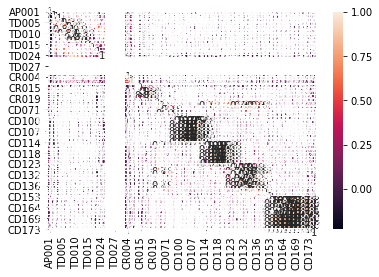

In [28]:
corrmat = df1[numerical_columns].corr()
sns.heatmap(corrmat, annot = True)

#### Scaling the data

The scaling method I chose represents each column in values from 0 to 1 according to their relative values. It creates less variance in data and smoothes it out to relative values making them easier to compare to each other.

In [26]:
df_1 = pd.concat([df1[numerical_columns], ohc_feats],axis=1) #df_1 do not contain target variable

In [27]:
# Define what type of scaling we will use 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

In [28]:
# Fit scaler to our data
scaler.fit(df_1[numerical_columns])

MinMaxScaler()

In [29]:
# Calculate scaled values and store them in a separate object
df_1[numerical_columns] = scaler.transform(df_1[numerical_columns])

In [30]:
#add label back to dataset
df_1['loan_default'] = df1['loan_default'].tolist()

In [31]:
#check missing values again
sum(df_1.isnull().sum()) #we've gotten rid of all our NAs

0

#### predictor and target

In [32]:
var = pd.DataFrame(df_1.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var.head(10)

,varname,dtype,source
0,AP001,float64,AP
1,TD001,float64,TD
2,TD002,float64,TD
3,TD005,float64,TD
4,TD006,float64,TD
5,TD009,float64,TD
6,TD010,float64,TD
7,TD013,float64,TD
8,TD014,float64,TD
9,TD015,float64,TD


In [33]:
var['source'].value_counts()

MB    112
CD     36
da     30
ho     23
AP     21
TD     17
CR      7
Da      6
mo      4
lo      1
Name: source, dtype: int64

In [34]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
# other remaining variables to get a dummy list
other_list = list(set(list(df_1.columns)).difference(set(MB_list+AP_list+TD_list+CR_list+PA_list+CD_list)))
other_list.remove('loan_default')

In [35]:
predictors = MB_list + TD_list + AP_list + CD_list + CR_list + PA_list + other_list
target='loan_default'

#### modelling

#### Search for the best model and do the grid search¶

In [38]:
# This function fits each model 100 times, resulting in 100 R-squares values.
# It outputs the distribution of the R-squared values.

def Get_R2(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[predictors], 
                                                                data[target], 
                                                                test_size= 0.3)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [(np.mean(r2_train)*100).round(2), 
                      (np.mean(r2_test)*100).round(2),
                      (np.quantile(r2_test,0.05)*100).round(2),
                      (np.quantile(r2_test,0.25)*100).round(2),
                      (np.quantile(r2_test,0.50)*100).round(2),
                      (np.quantile(r2_test,0.75)*100).round(2),
                      (np.quantile(r2_test,0.95)*100).round(2)]
    return pd.DataFrame(results).set_index(pd.Series(['Train_R2','Test_R2_mean',
                                                      'Test_R2_5%','Test_R2_25%',
                                                      'Test_R2_50%','Test_R2_75%',
                                                      'Test_R2_95%'
                                                     ]))

In [79]:
models = {'OLS': linear_model.LinearRegression(),
         'Lasso': linear_model.Lasso(),
         'Ridge': linear_model.Ridge(),}

In [80]:
Get_R2(models, df_1)

,OLS,Lasso,Ridge
Train_R2,7.510000e+00,0.00,7.50
Test_R2_mean,-2.756303e+22,-0.00,6.72
Test_R2_5%,-1.101945e+23,-0.02,6.33
Test_R2_25%,-1.678652e+22,-0.01,6.60
Test_R2_50%,-4.097973e+21,-0.00,6.73
Test_R2_75%,-8.192330e+20,-0.00,6.86
Test_R2_95%,-1.873377e+19,-0.00,7.03


obviously, ridge performed better than other two models.

In [36]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03,0.05, 0.1, 0.2, 0.3, 0.5, 1,5,10,200,300,400,500]}
ridge_params = {'alpha':[1, 10, 30, 50, 100,200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': linear_model.LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params).fit(df_1[predictors], df_1[target]).best_estimator_,
           'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(df_1[predictors], df_1[target]).best_estimator_,}

In [40]:
Get_R2(models2, df_1)

,OLS,Lasso,Ridge
Train_R2,7.500000e+00,0.00,7.33
Test_R2_mean,-1.859372e+23,-0.00,6.86
Test_R2_5%,-2.954464e+23,-0.02,6.41
Test_R2_25%,-1.684977e+22,-0.01,6.69
Test_R2_50%,-3.907877e+21,-0.00,6.87
Test_R2_75%,-6.927252e+20,-0.00,7.02
Test_R2_95%,-2.353491e+19,-0.00,7.27


In [41]:
models2

{'OLS': LinearRegression(),
 'Lasso': Lasso(alpha=0.02),
 'Ridge': Ridge(alpha=50)}

in this case, it is obvious that ridge performs better.

#### Explain your model coefficients & performance

In [42]:
#Best model
Best_model = linear_model.Ridge(alpha=50).fit(df_1[predictors], df_1[target])
Best_model

Ridge(alpha=50)

In [43]:
pd.Series(Best_model.coef_)

0     -0.096425
1     -0.015581
2      0.000571
3     -0.005389
4     -0.004971
         ...   
251    0.012552
252   -0.000666
253    0.001904
254   -0.012060
255    0.009767
Length: 256, dtype: float64

In [44]:
corr=pd.concat([pd.Series(predictors),pd.Series(Best_model.coef_)],axis=1)

In [55]:
corr.columns = ['predictor','correlation']

In [57]:
corr.sort_values(by=['correlation'],ascending= False)

,predictor,correlation
137,AP004_12,0.178432
160,CD113,0.169146
118,TD013,0.150491
136,AP004_9,0.129976
161,CD114,0.123184
...,...,...
0,MB005,-0.096425
163,CD117,-0.099858
132,AP003_4,-0.118899
158,CD107,-0.129400


In [90]:
def actual_predict(model,df,target):
    y_pred = pd.DataFrame(model.predict(df[predictors]))
    y_actual = df[target]
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)

Actual_predict = actual_predict(Best_model,df_1,target)
Actual_predict.head()

,actual,pred
0,1,0.215988
1,0,0.249764
2,0,0.178870
3,0,0.063107
4,0,0.159279


In [91]:
def ROC_PR(df_actual_predict):
    
    # ROC
    from sklearn.metrics import roc_curve,roc_auc_score, auc 
    from sklearn.metrics import average_precision_score, precision_recall_curve

    roc_auc_value = roc_auc_score(df_actual_predict['actual'],df_actual_predict['pred'])
    fpr, tpr, _ = roc_curve(df_actual_predict['actual'],df_actual_predict['pred'])
    roc_auc = auc(fpr,tpr)
    
    import matplotlib.pyplot as plt
    lw=2
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr, color='darkorange',lw=lw,label='AUC = %0.4f)' %roc_auc_value)
    plt.plot([0,1],[0,1], color='navy',lw=lw,linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: AUC={0:0.4f}'.format(roc_auc_value))
    plt.legend(loc='lower right')
    
    # Precision-Recall
    plt.subplot(1,2,2)
    average_precision = average_precision_score(df_actual_predict['actual'],df_actual_predict['pred'])
    precision, recall, _ = precision_recall_curve(df_actual_predict['actual'],df_actual_predict['pred'])
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.ylim([0.0,1.05])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))

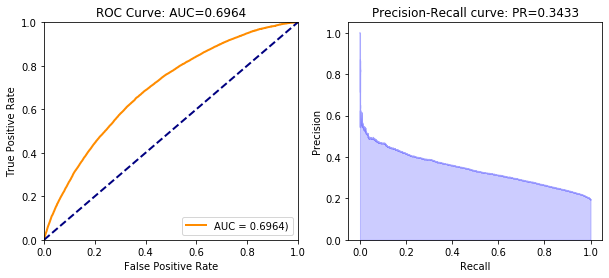

In [93]:
ROC_PR(Actual_predict)

#### Use the Gains table to explain cost & benefit

In [95]:
def gains_table(df_actual_predict):
    df_actual_predict = df_actual_predict.sort_values(by='pred',ascending=False)
    df_actual_predict['row_id'] = range(0,0+len(df_actual_predict))
    
    df_actual_predict['decile'] = (df_actual_predict['row_id'] / (len(df_actual_predict)/10)).astype(int)
    df_actual_predict.loc[df_actual_predict['decile'] == 10] =9
    
    # Create gains table
    gains = df_actual_predict.groupby('decile')['actual'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual']  ) * 100 
    gains['gain'] = (gains['cum_actual'] / gains['cum_count']*100).round(2)
    return(gains)

In [96]:
gains = gains_table(Actual_predict)
gains

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,8000,3287,4713,8000,3287,4713,0.21,0.07,1548.8,2.12,14.0,41.09
1,8000,2560,5440,16000,5847,10153,0.38,0.16,3097.6,1.89,22.0,36.54
2,8000,2071,5929,24000,7918,16082,0.51,0.25,4646.4,1.70,26.0,32.99
3,8000,1849,6151,32000,9767,22233,0.63,0.34,6195.2,1.58,29.0,30.52
4,8000,1506,6494,40000,11273,28727,0.73,0.45,7744.0,1.46,28.0,28.18
5,8000,1264,6736,48000,12537,35463,0.81,0.55,9292.8,1.35,26.0,26.12
6,8000,1065,6935,56000,13602,42398,0.88,0.66,10841.6,1.25,22.0,24.29
7,8000,873,7127,64000,14475,49525,0.93,0.77,12390.4,1.17,16.0,22.62
8,8000,663,7337,72000,15138,56862,0.98,0.88,13939.2,1.09,10.0,21.02


The top 10% observations contain 21% of the targets. By escalating the top 10% for review, we can get 21% of the targets.Here we can see the lift in the first decile is 2.12. This suggests the model allows addressing almost two times more targets for this group, compared with addressing without the model, that is randomly.

#### Save the model as a pickle file to be used in production

In [98]:
import pickle
# save the model to disk
filename = '/Users/jiayangdu/Desktop/Columbia University /APAN 5420/best_model.pkl'
pickle.dump(Best_model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(df_1[predictors])
print(result)

[0.2159882  0.24976419 0.17886969 ... 0.24896449 0.16312184 0.20690265]
